# Verifying the dataset samples

This notebook will use the UCI-HAR view (unbalanced_20Hz_train_test-v1) and will:

1. Apply DFT over dataset windows
2. ...
.
.
.
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import UCIHAR_UnbalancedView20Hz
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-11 11:43:23.286813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 11:43:23.286832: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# UCI-HAR Loader
loader = UCIHAR_UnbalancedView20Hz(
    "../../data/views/UCI-HAR/unbalanced_20Hz_train_test-v1", 
    download=False
)

train_val, test = loader.load(concat_train_validation=True, label="standard activity code")
train_val.data['standard activity code'] = train_val.data['standard activity code'].astype('int')

# View balanceada a 100Hz para comparar
# loader = KuHarResampledView20HZ("../../data/old-views/KuHar/balanced_view", download=False)
# train_val, test = loader.load(concat_train_validation=True)


In [4]:
train_val.window_names, train_val.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [5]:
# Checking the whole data...
train_val[:][0]

array([[ 3.56506297e-03,  8.90071661e-03,  5.80060013e-03, ...,
         3.01458502e-03,  1.05945887e-02,  3.47046738e-03],
       [ 1.26555639e-03, -1.77358598e-03,  1.17170143e-03, ...,
        -9.85448114e-03, -3.15336251e-03,  1.08089870e-04],
       [ 5.46312646e-04, -9.07990168e-04, -1.51287591e-03, ...,
         5.81651307e-04,  1.02182053e-02,  2.11202546e-02],
       ...,
       [ 1.32816994e-01,  4.60200733e-01,  5.30693248e-01, ...,
         3.15336514e-01,  8.08160430e-02,  3.26849712e-01],
       [-1.11180980e-01, -3.36622303e-01, -3.29961951e-01, ...,
         1.15644230e-01,  9.23753538e-02,  2.98366635e-01],
       [-1.37922328e-01, -5.34447075e-02,  2.60768845e-01, ...,
        -5.58013347e-01, -7.94043247e-01, -7.22394557e-01]])

In [6]:
train_val[0][0].shape

(360,)

In [7]:
train_val.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user,standard activity code
0,0.003565,0.008901,0.005801,0.004948,0.006308,0.005960,0.005928,0.006170,0.007250,0.006326,...,0.000240,-0.000519,-0.001399,0.001455,0.003015,0.010595,0.003470,5,1,1
1,0.001266,-0.001774,0.001172,0.000990,-0.000784,-0.001122,0.002905,0.002715,-0.000973,0.000815,...,-0.000780,-0.005341,-0.009295,-0.011561,-0.009854,-0.003153,0.000108,5,1,1
2,0.000546,-0.000908,-0.001513,-0.001802,0.000595,0.001365,-0.001567,-0.000779,-0.000577,-0.000263,...,-0.000859,0.001881,0.003989,0.002610,0.000582,0.010218,0.021120,5,1,1
3,0.003104,0.001146,-0.004158,0.001729,-0.000769,0.001305,0.003918,-0.002209,-0.000397,-0.001232,...,-0.002719,0.003975,0.001041,-0.004906,0.000427,-0.000771,-0.013023,5,1,1
4,-0.001820,0.000755,0.001618,0.002065,-0.000736,-0.001323,0.002889,-0.001119,0.001074,-0.003958,...,0.002172,0.000114,0.000322,-0.001916,0.001534,0.002732,0.007108,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454,0.013458,-0.070288,0.069952,0.026208,0.137807,0.375901,0.596737,0.329611,0.043722,-0.056924,...,-0.218047,-0.547776,-0.612564,-0.837015,-0.729588,-0.472352,-0.211776,2,30,3
2455,0.140879,0.144345,0.464152,0.456810,0.267120,-0.026908,-0.131830,-0.147693,-0.364213,-0.355118,...,-0.476739,-0.819931,-0.750365,-0.630116,-0.337958,0.013349,0.153647,2,30,3
2456,0.132817,0.460201,0.530693,0.298639,0.018089,-0.059733,-0.115499,-0.287280,-0.350470,-0.343768,...,0.120246,0.357961,0.001281,-0.054251,0.315337,0.080816,0.326850,2,30,3
2457,-0.111181,-0.336622,-0.329962,-0.202659,-0.255559,-0.228172,-0.063806,0.102427,0.427488,0.676010,...,-0.229515,0.025977,0.066758,0.067897,0.115644,0.092375,0.298367,2,30,3


In [8]:
train_val.data.describe()

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,standard activity code
count,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,...,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000
mean,-0.001020,-0.005486,0.002309,0.005753,0.010899,0.012440,0.012285,0.001020,-0.003707,-0.006196,...,-0.002463,-0.002166,-0.002622,0.001427,0.006749,0.001851,-0.006293,-0.008514,-0.000086,1.823505
std,0.159818,0.210006,0.205100,0.208734,0.216568,0.207665,0.217256,0.212752,0.208695,0.210087,...,0.258137,0.265572,0.268943,0.267148,0.274432,0.284015,0.281215,0.267705,0.286580,1.381825
min,-0.605072,-0.711929,-0.653227,-0.629666,-0.627234,-0.731351,-0.721473,-0.670333,-0.726013,-0.715845,...,-1.898094,-1.444096,-1.439120,-1.955950,-2.475032,-2.569486,-2.106964,-1.518222,-1.645927,0.000000
25%,-0.051982,-0.082375,-0.069601,-0.058547,-0.065387,-0.057767,-0.058286,-0.078498,-0.080593,-0.090052,...,-0.056724,-0.058407,-0.050266,-0.051085,-0.046196,-0.044151,-0.049555,-0.064151,-0.051739,1.000000
50%,-0.000473,-0.000883,-0.000383,-0.000289,-0.000288,-0.000107,-0.000480,-0.000454,-0.000597,-0.000904,...,0.001449,0.001242,0.001578,0.001019,0.001130,0.000863,0.001042,0.000391,0.000997,2.000000
75%,0.012003,0.017996,0.022660,0.029490,0.028012,0.035528,0.021121,0.020569,0.016922,0.012653,...,0.068657,0.069334,0.076013,0.070717,0.074203,0.069636,0.070457,0.061441,0.082245,3.000000
max,0.943568,1.081146,1.059412,1.052624,1.017454,1.030662,1.048605,1.007136,1.057737,1.076464,...,1.324730,1.132931,1.198626,1.344457,1.498597,2.110432,1.639234,1.361174,1.410843,4.000000


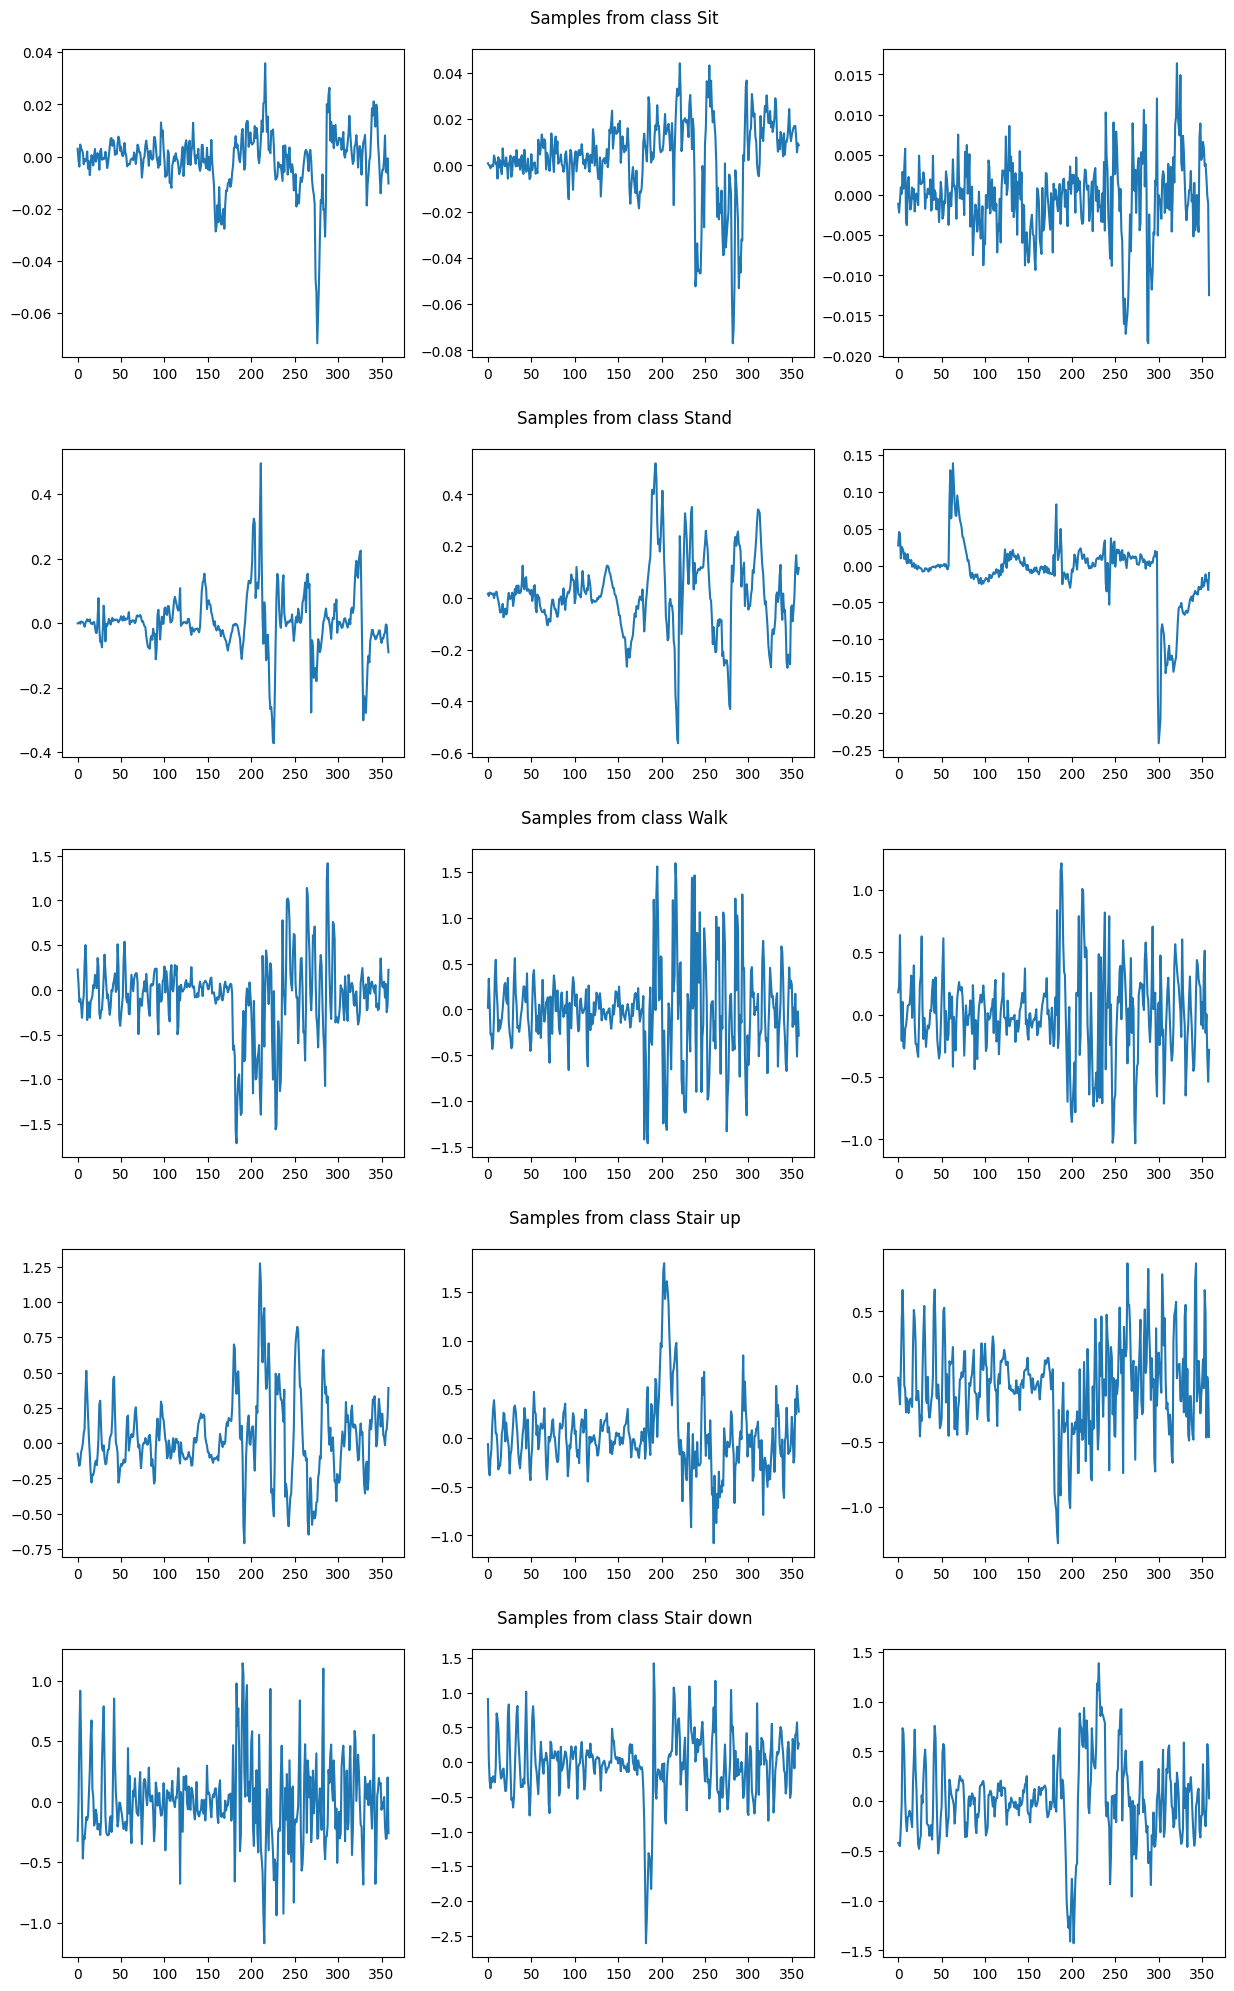

In [9]:
labels = {0: "Sit", 1: "Stand", 2: "Walk", 3: "Stair up", 4: "Stair down", 5: "Run"}
samples_per_class = 3
# data_grouped = train_val.data.groupby('standard activity code', sort=True).apply(lambda x: x.sample(samples_per_class)).iloc[:,1:-3]
# print(data_grouped)
data_grouped = train_val.data.groupby('standard activity code', sort=True).sample(samples_per_class).iloc[:,1:-3]
# print(data_grouped)
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(15)

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=5, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'Samples from class {labels[row]}')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        x = np.array(data_grouped.iloc[row*samples_per_class+col])
        ax.plot(x)

In [10]:
# Create the objects
#scaler_transform = WindowedTransform(
#    transform=train_scaler, fit_on=None, transform_on="all")

fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[#scaler_transform,
                fft_transform], new_window_name_prefix="scaled."
)

In [11]:
# Transform it and generate a new dataset!
train_val_fft = transformer(train_val)
test_fft = transformer(test)

In [12]:
# Checking the whole data...
train_val_fft[:][0]

array([[1.11734530e-01, 8.30443465e-02, 4.47117293e-02, ...,
        2.42990076e-02, 7.53772575e-03, 1.40963309e-02],
       [2.64837062e-02, 2.88036369e-02, 2.24196962e-02, ...,
        1.34689770e-02, 1.08509669e-02, 2.80202713e-02],
       [6.04641919e-03, 9.92514919e-03, 2.08227008e-03, ...,
        1.55683489e-02, 1.96263513e-02, 9.37579756e-03],
       ...,
       [1.05076294e+00, 1.86185627e+00, 3.85436312e+00, ...,
        4.52838714e-01, 3.70347563e-01, 4.94145950e-01],
       [1.21420043e+00, 5.10711224e-01, 3.24773425e+00, ...,
        3.09388716e-01, 4.52037700e-01, 1.51720676e-01],
       [2.83281658e-01, 1.64391727e-01, 1.45082857e+00, ...,
        1.30106451e-01, 5.84838144e-01, 7.92212757e-01]])

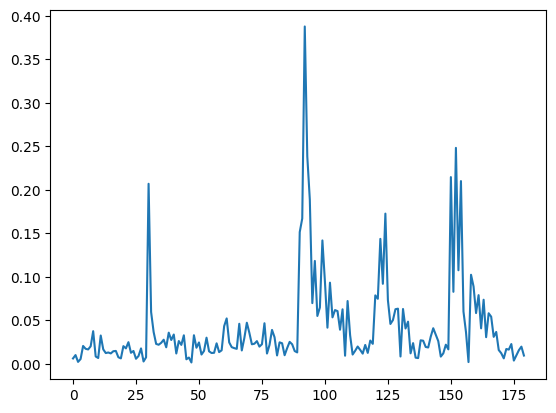

In [13]:
plt.plot(train_val_fft[2][0])

In [14]:
test

PandasMultiModalDataset: samples=997, features=360, no. window=6, label_columns='standard activity code'

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [15]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    normalize='true'
)

### RandomForest (Domínio do Tempo)

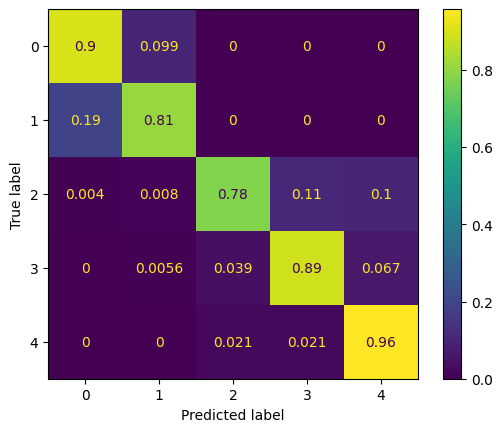

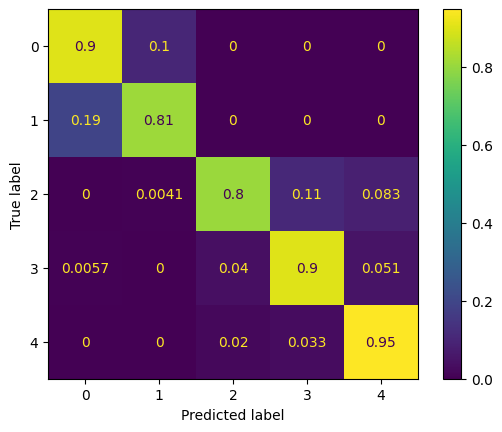

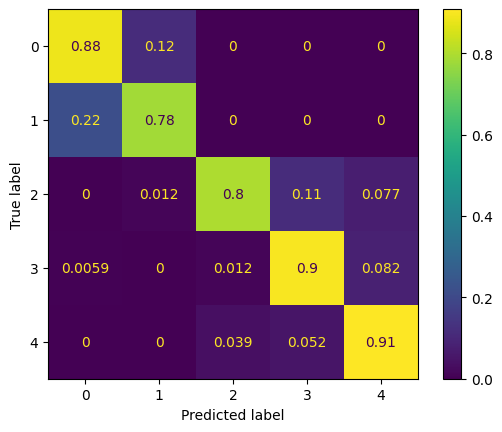

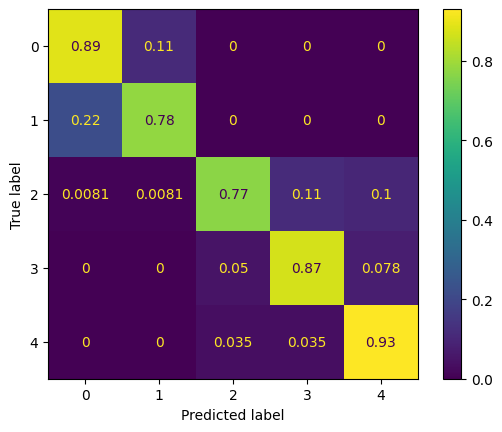

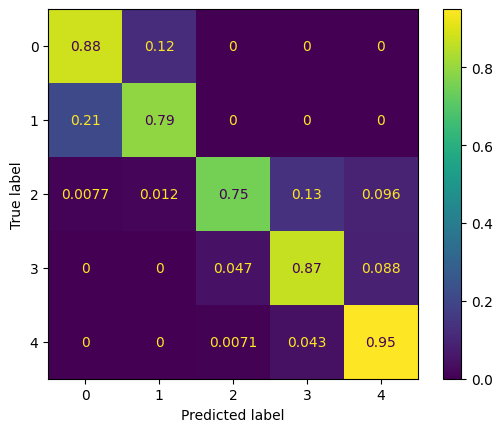

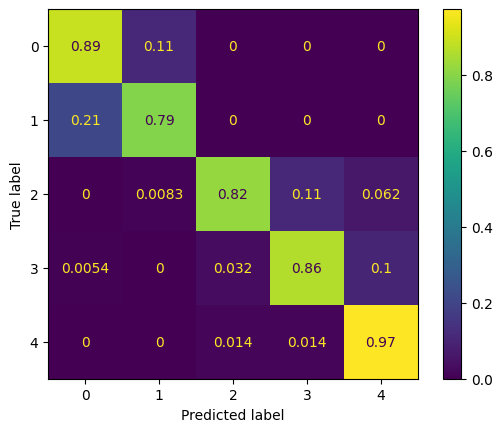

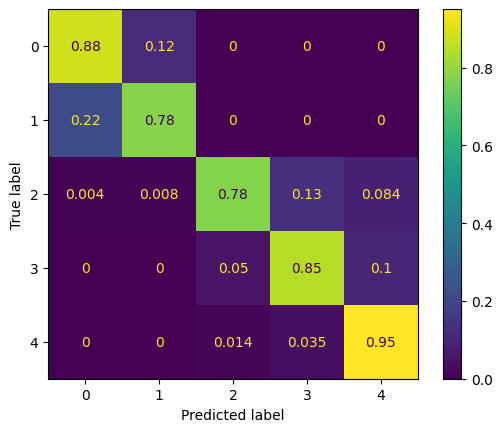

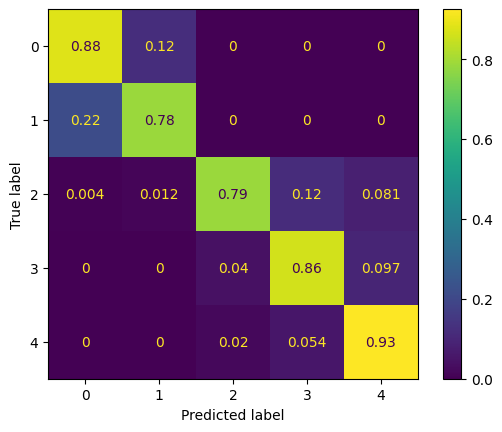

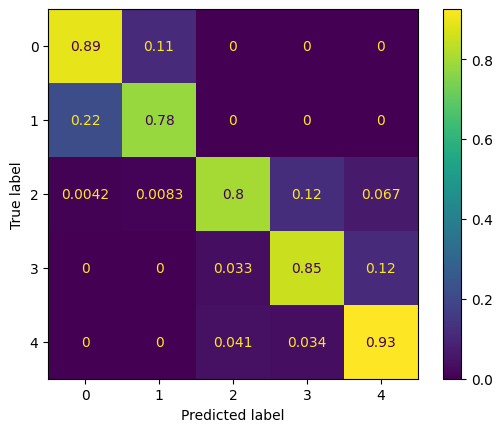

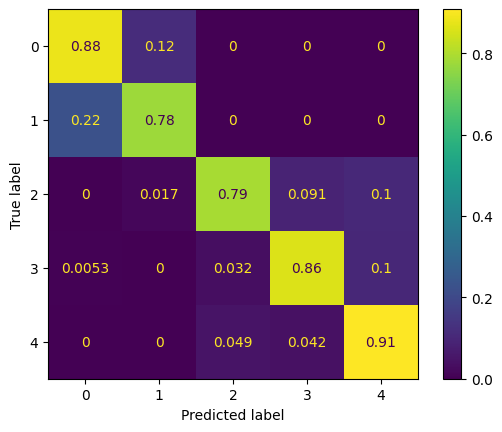

Mean accuracy (10 runs): 0.8407. Mean f1-score: 0.8418
Standard deviation accuracy (10 runs): 0.0101. Standard deviation f1-score: 0.0099


In [16]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_val, [test])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### RandomForest (Domínio da Frequência)

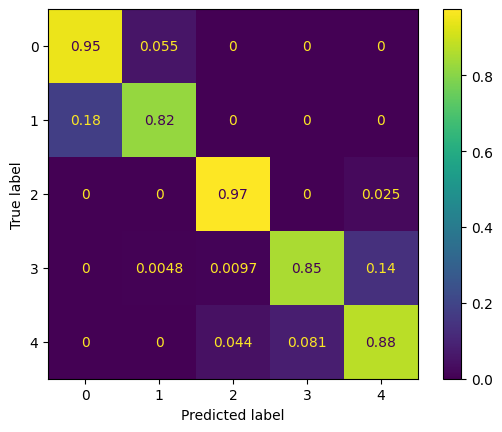

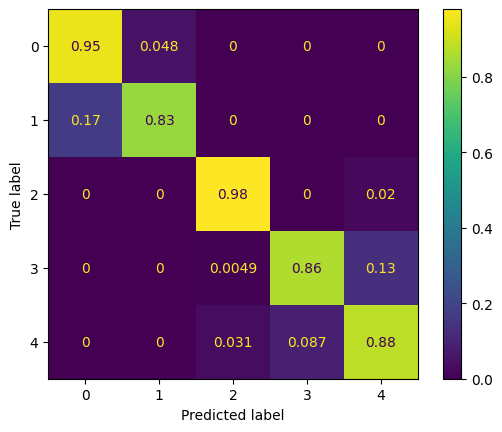

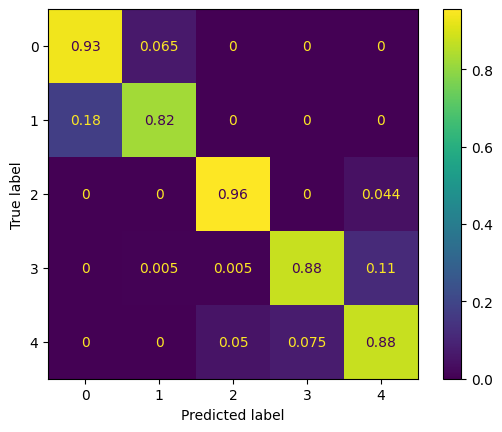

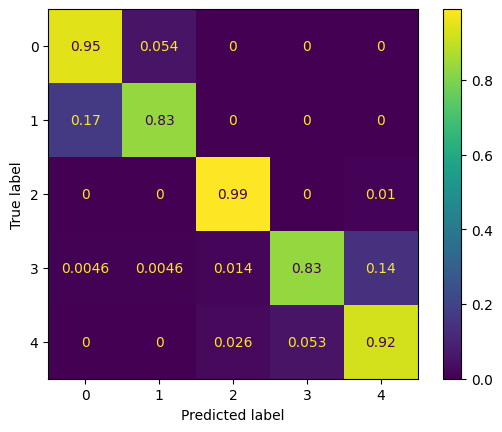

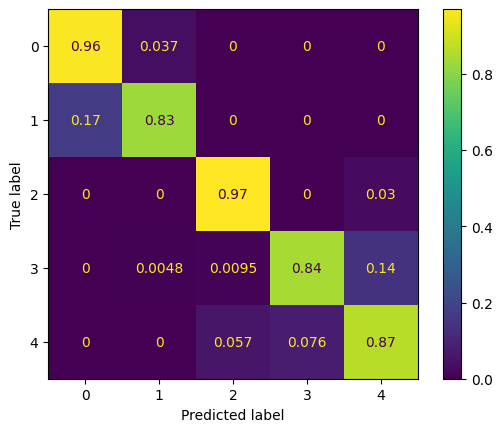

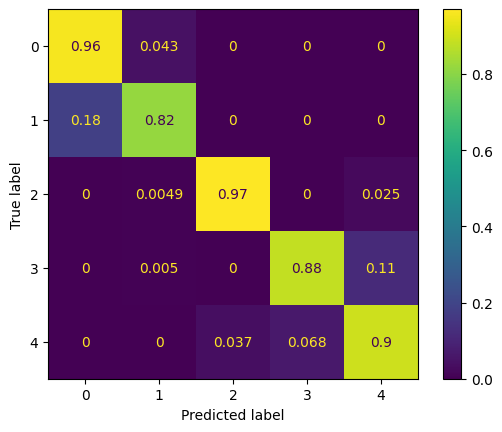

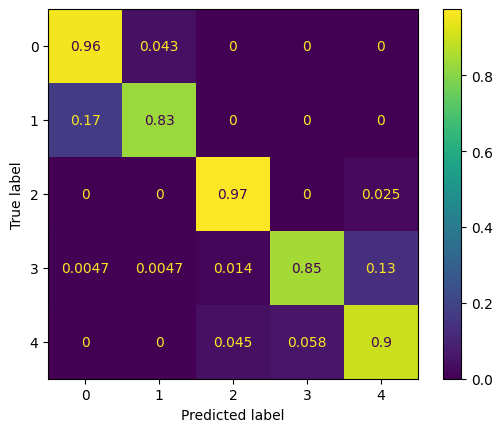

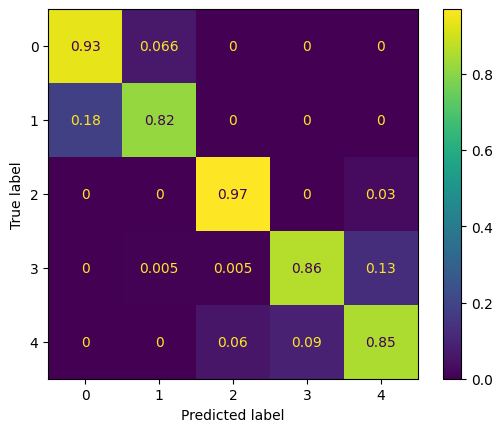

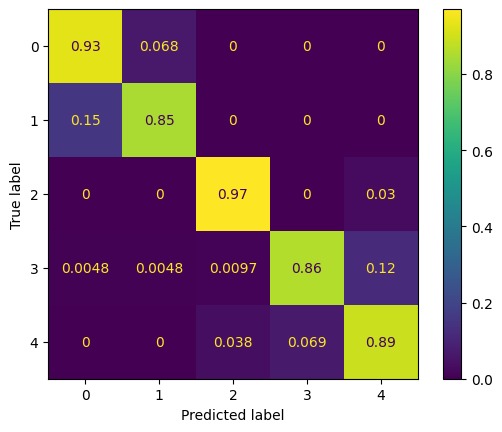

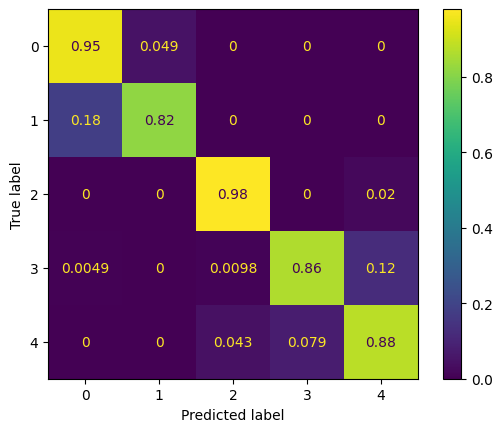

Mean accuracy (10 runs): 0.8914. Mean f1-score: 0.8922
Standard deviation accuracy (10 runs): 0.0049. Standard deviation f1-score: 0.0049


In [17]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### SVM

In [18]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=SVC,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# std_acc = np.std(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# std_f1 = np.std(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
# print(f"Standard deviation accuracy (1 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### KNN

In [19]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=KNeighborsClassifier,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# std_acc = np.std(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# std_f1 = np.std(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (1 run): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
# print(f"Standard deviation accuracy (1 run): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

## Plot UMAP and T-SNE

In [20]:
def plot(df, figsize: tuple = (8, 8), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [21]:
labels = {0: "Sit", 1: "Stand", 2: "Walk", 3: "Stair up", 4: "Stair down", 5: "Run"}
print(labels)

{0: 'Sit', 1: 'Stand', 2: 'Walk', 3: 'Stair up', 4: 'Stair down', 5: 'Run'}


### UMAP (Domínio do Tempo)

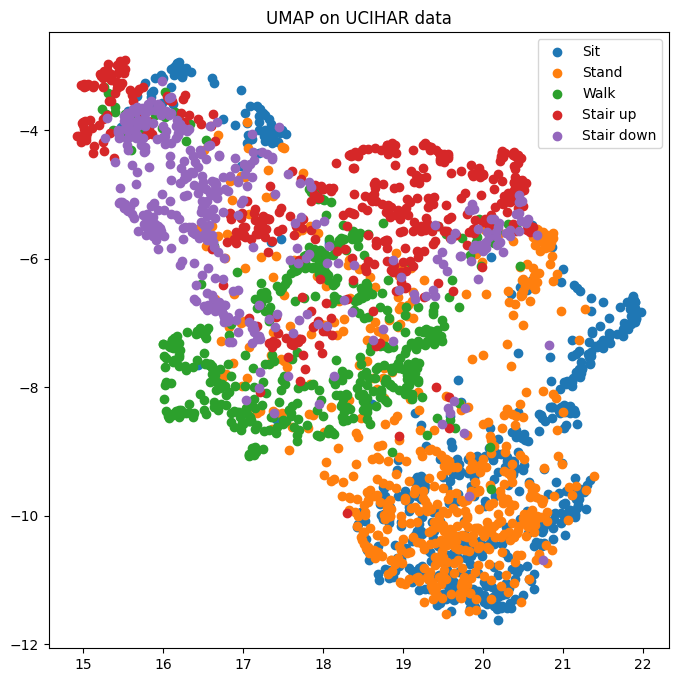

In [22]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val[:][0]), columns=["x", "y"])
result["label"] = train_val[:][1]
plot(result, title="UMAP on UCIHAR data", labels = labels)

### T-SNE (Domínio do Tempo)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


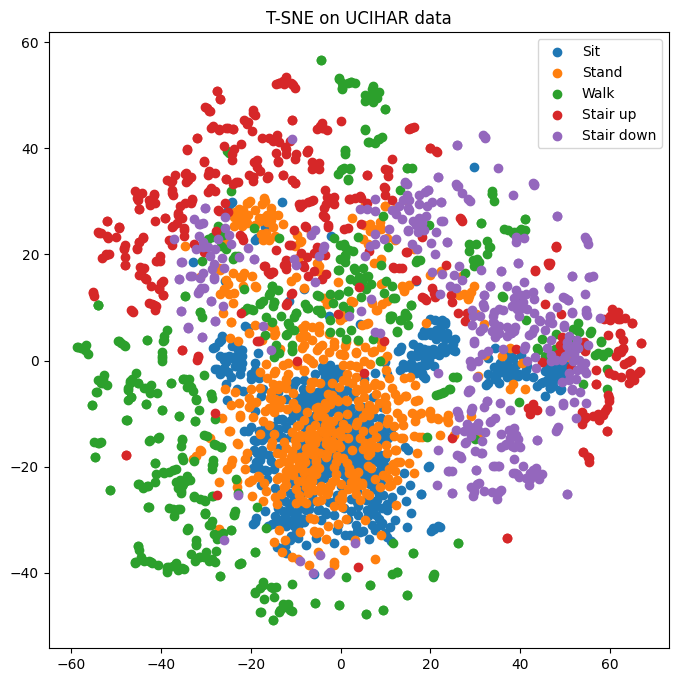

In [23]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val[:][0]), columns=["x", "y"])
result["label"] = train_val[:][1]
plot(result, title="T-SNE on UCIHAR data", labels=labels)

### UMAP (Domínio da Frequência)

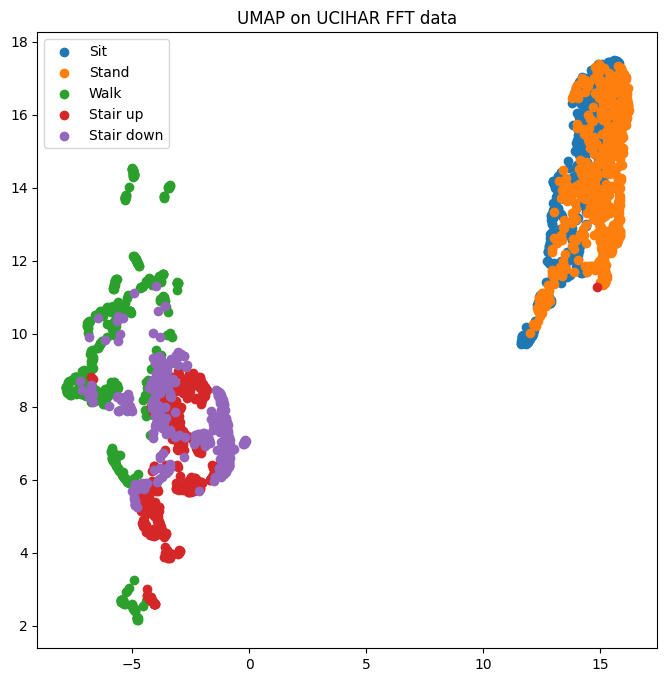

In [24]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="UMAP on UCIHAR FFT data", labels = labels)

### T-SNE (Domínio da Frequência)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


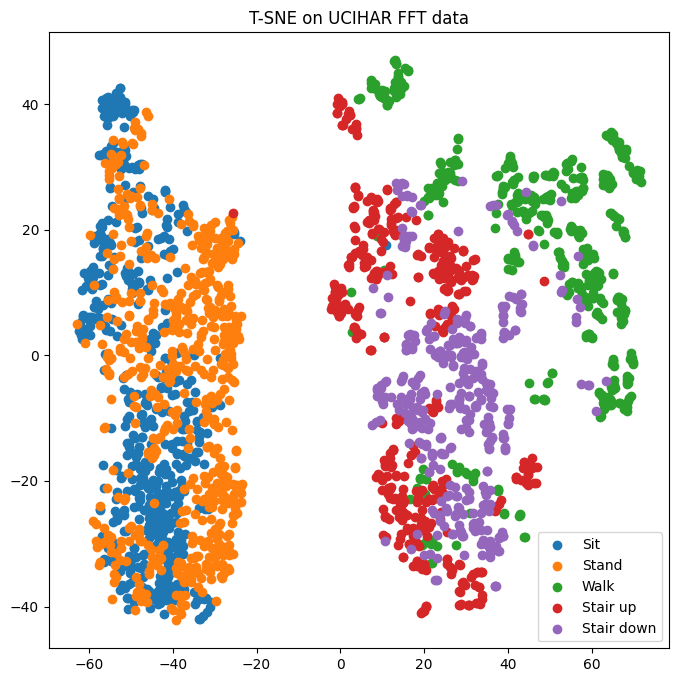

In [25]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="T-SNE on UCIHAR FFT data", labels=labels)